In [7]:
import os, sys
import numpy as np
import mlx.core as mx
import matplotlib.pyplot as plt
from PIL import Image

sys.path.insert(0, os.path.abspath('../../../'))
# import decord

In [8]:
print(sys.path[0])

/Users/deekshith/Documents/Projects/multimodal_models/mlx_perception_models


In [9]:
import core.vision_encoder.pe as pe
import core.vision_encoder.transforms as transforms

model_name = 'PE-Core-B16-224' 
# models available: ['PE-Core-G14-448', 'PE-Core-L14-336', 'PE-Core-B16-224']

model = pe.CLIP.from_config(model_name, pretrained=True)  # Downloads from HF

preprocess = transforms.get_image_transform(model.image_size)
tokenizer = transforms.get_text_tokenizer(model.context_length)

### Example 1: Image and Text Feature Extraction for Zero-shot Image Classification/Retrieval

In this example, we extract the embedding of a cat image, and the embeddings of 3 senetence. We measure the cosine similarites between the image and sentences.

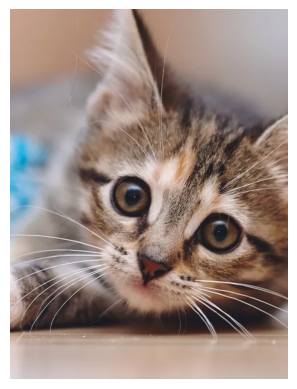

Captions: ['a diagram', 'a dog', 'a cat']
Label probs: 0.00 0.00 1.00
This image is about a cat


In [10]:
image = preprocess(Image.open("assets/cat.png"))[None]
captions = ["a diagram", "a dog", "a cat"]
text = tokenizer(captions)

image_features = model.encode_image(image, normalize=True)
text_features = model.encode_text(text, normalize=True)
# image_features /= image_features.norm(dim=-1, keepdim=True)
# text_features /= text_features.norm(dim=-1, keepdim=True)
text_probs = np.array(mx.softmax(100.0 * image_features @ text_features.T, axis=-1))[0]

plt.imshow(Image.open("assets/cat.png"))
plt.axis('off')
plt.show()
print("Captions:", captions)
print("Label probs:", ' '.join(['{:.2f}'.format(prob) for prob in text_probs]))  # prints: [[0.00, 0.00, 1.00]]
print(f"This image is about {captions[text_probs.argmax()]}")

### Example 2: Video and Text Feature Extraction for Zero-shot Video Classification/Retrieval

In this example, we extract the embedding of a dog video, and the embeddings of 3 senetence. We measure the cosine similarites between the video and sentences. We first create a simple video preprocess function to process video input

In [18]:
import cv2

def preprocess_video(video_path, num_frames=8, transform=None, return_first_frame_for_demo=True):
    cap = cv2.VideoCapture(video_path)
    frames = []
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    frame_indices = np.linspace(0, total_frames - 1, num_frames).astype(int)
    for i in range(total_frames):
        ret, frame = cap.read()
        if not ret:
            break
        if i in frame_indices:
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            frame_pil = Image.fromarray(frame)
            frames.append(frame_pil)
    
    cap.release()
    
    first_frame = None
    if return_first_frame_for_demo and frames:
        first_frame = frames[0]

    if transform:
        frames = [transform(frame) for frame in frames]
    
    return mx.stack(frames, axis=0), first_frame

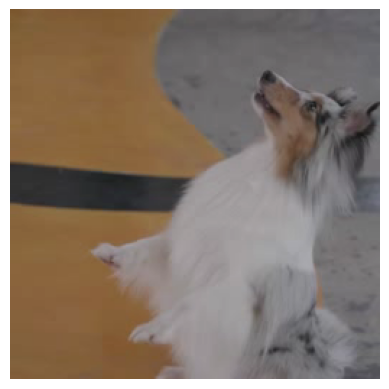

Captions: ['a diagram', 'a dog', 'a cat']
Label probs: 0.00 1.00 0.00
This video is about a dog


In [20]:
video, first_frame = preprocess_video("assets/dog.mp4", 8, transform=preprocess)
video = video[None]
text = tokenizer(["a diagram", "a dog", "a cat"])

image_features = model.encode_video(video, normalize=True)
text_features = model.encode_text(text, normalize=True)
# image_features /= image_features.norm(dim=-1, keepdim=True)
# text_features /= text_features.norm(dim=-1, keepdim=True)
text_probs = np.array(mx.softmax(100.0 * image_features @ text_features.T, axis=-1))[0]

plt.imshow(first_frame)
plt.axis('off')
plt.show()
print("Captions:", captions)
print("Label probs:", ' '.join(['{:.2f}'.format(prob) for prob in text_probs]))  # prints: [[0.00, 1.00, 0.00]]
print(f"This video is about {captions[text_probs.argmax()]}")